# Game of Life


The [Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern (generation 0) constitutes the "seed" of the system.
Time is considered discrete, and each time step (sometimes called a tick), the previous rules are applied simultaneously to every cell in the grid; "births" and "deaths" are immediate.
Each generation is a pure function of the previous generation alone.


## Assignments

* Begin by implementing the GoF's rules and create few examples with basic seeds in small dimensions. Hint: create `.gif` animations from sequences of still `.png` images
* Implement examples of the three categories of patterns *still lifes*, *oscillators* and *spaceships* (check the [wiki link](http://en.wikipedia.org/wiki/Conway's_Game_of_Life))
* Analyse the evolutions of these patterns in terms of frequency (the number of cycles required to return to the original configuration, if any), occupancy (how many alive cells there are at every step of the game), replication or heat (the average number of cells that change state at each generation), speed (if applicable), etc.
* Increase the size of the GoF's world and play with more advanced and complex patterns

In [12]:
import copy
import numpy as np
import csv
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display, Image as IPyImage

In [2]:
class State:
    """ 
    Represents the state of a Game of Life iteration as
    a set of alive cells. 
    A cell is represented as a (x,y) tuple of coordinates.
    The origin is considered in the top-left corner.
    """
    
    def __init__(self, grid_size, initial_state):
        """
        Initialize the state with the grid dimension and
        the starting seed represented as a set of
        alive cells' coordinates.
        """
        self.grid_size = grid_size
        if initial_state == None:
            self.state = set()
        else:
            self.state = initial_state
                
    def alive_cells(self):
        """ Returns the set of alive cells. """
        return self.state
            
    def is_alive(self, cell):
        """ Given a cell returns True if the cell is alive. """
        return cell in self.state
    
    def kill(self, cell):
        """ Kills the given cell. """
        self.state.remove(cell)
    
    def revitalize(self, cell):
        """ Revitalizes the given cell if dead. """
        if cell[0] < self.grid_size[0] and cell[1] < self.grid_size[1]:
            self.state.add(cell)
        else:
            print("Grid dimensions exceeded, cell has not been loaded")
        
    def neighbours(self, cell):
        """ Returns the 8 neighbouring cells. """
        offsets = [(x,y) for x in range(-1,2) for y in range(-1,2) if not (x == 0 and y == 0)]
        neighbours = set()
        for offset in offsets:
            x, y = cell[0] - offset[0], cell[1] - offset[1]
            if x < self.grid_size[0] and y < self.grid_size[1] and x >= 0 and y >= 0:
                neighbours.add((x,y))
        return neighbours
    
    def count_alive_neighbours(self, cell):
        """ Returns the number of alive neighbours of the given cell. """
        neighbours = self.neighbours(cell)
        count = 0
        for neighbour in neighbours:
            if self.is_alive(neighbour):
                count += 1
        return count
    
    def __eq__(self, other):
        if isinstance(other, State):
            return self.state == other.state
        return False
    
    def get_frame(self, size):
        """ Returns the state represented as a grayscale frame of the given size. """
        frame = np.zeros(self.grid_size, dtype=np.uint8)
        for cell in self.alive_cells():
            # cell is (x,y) frame has shape (rows, cols)
            frame[cell[1], cell[0]] = 255
        frame = Image.fromarray(frame)
        frame = frame.resize(size, resample=Image.NEAREST)
        return frame

In [3]:
class Game:
    
    def __init__(self, initial_state=None, grid_size=(64, 64)):
        self.size = grid_size
        self.state = State(grid_size, initial_state)
        self.history = []
        
    def run(self, iterations):
        """ Run the game for the given number of iterations. """
        
        count_cells_alive = []
        
        for _ in range(iterations):
            
            # keep track of the state
            # TODO: render immediately image or save the 'raw' state?
            self.history.append(self.state)
            
            prev_state = self.state
            curr_state = copy.deepcopy(self.state)
            
            for cell in prev_state.alive_cells():
                
                # Any live cell with fewer than two live neighbours dies, as if by underpopulation.
                # Any live cell with more than three live neighbours dies, as if by overcrowding.
                alive_neighbours = prev_state.count_alive_neighbours(cell)
                if alive_neighbours < 2 or alive_neighbours > 3:
                    curr_state.kill(cell)
                # Any live cell with two or three live neighbours lives, unchanged, to the next generation.
                
                # Any dead cell with exactly three live neighbours becomes a live cell.
                neighbours = prev_state.neighbours(cell)
                for neighbour in neighbours:
                    alive_neighbours = prev_state.count_alive_neighbours(neighbour)
                    if alive_neighbours == 3:
                        curr_state.revitalize(neighbour)
                    
            self.state = curr_state
            
            if prev_state == curr_state:
                print('break')
                break
            
            #keep track of the number of active cells at each iteration
            count_cells_alive.append(len(curr_state.alive_cells()))
        
        return count_cells_alive
    
    # https://pillow.readthedocs.io/en/latest/handbook/image-file-formats.html#saving-sequences
    def export_gif(self, filename, size=(512,512), frametime=200):
        """ Export the game history as an animated gif of the given resolution. """
        frames = []
        for state in self.history:
            frames.append(state.get_frame(size))            
        frames[0].save(filename, save_all=True, append_images=frames[1:], duration=frametime, loop=0)

    def load_pattern(self, pattern, pattern_pos):
        """ Load a specific pattern in the game. """
        for cell in pattern:
            cell = (cell[0] + pattern_pos[0], cell[1] + pattern_pos[1])
            self.state.revitalize(cell)

In [4]:
class PatternLibrary:
    
    def  __init__(self, csv_filename):        
        # read the patterns
        raw_patterns = {}
        with open(csv_filename, newline='', encoding='utf-8-sig') as csvfile:
            rows = csv.reader(csvfile, delimiter=';')
            pattern_name = ''
            for row in rows:
                if row[0] not in ['', '1']:
                    pattern_name = row[0]
                    raw_patterns[pattern_name] = []
                else:
                    raw_patterns[pattern_name].append(row)
                    
        # parse the patterns
        self.patterns = {}            
        for name, pattern in raw_patterns.items():
            self.patterns[name] = set()
            for y, row in enumerate(pattern):
                for x, cell in enumerate(row):
                    if cell == '1':
                        self.patterns[name].add((x,y))
        
    def __len__(self):
        return len(self.patterns)
    
    def get_names(self):
        """ Returns the list of pattern names in the library. """
        return list(self.patterns.keys())
                
    def get_pattern(self, name):
        """ Returns the pattern with the given name. """
        return self.patterns[name]

In [5]:
library = PatternLibrary('patterns.csv')
print('Patterns in the library:', library.get_names())

Patterns in the library: ['glider', 'blinker', 'beacon', 'toad', 'diehard', 'acorn']


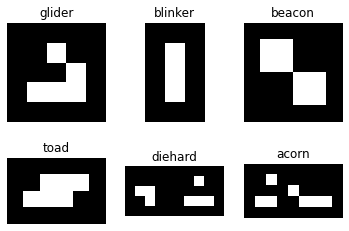

In [6]:
def to_numpy(pattern, pad=1):
    """ Returns a given pattern as a numpy array. """
    rows = []
    cols = []    
    for x, y in pattern:
        rows.append(y)
        cols.append(x)
        
    frame = np.zeros((max(rows)+1+2*pad, max(cols)+1+2*pad), dtype=np.uint8)
    for cell in pattern:
        frame[cell[1]+pad, cell[0]+pad] = 255
        
    return frame

patterns_names = library.get_names()
ncols = 3
nrows = int(np.ceil(len(library) / ncols))
fig, axs = plt.subplots(nrows, ncols)
for i, ax in enumerate(axs.flatten()):
    if i < len(library):
        ax.imshow(to_numpy(library.get_pattern(patterns_names[i])), cmap='gray')
        ax.set_title(patterns_names[i])
    ax.axis('off')

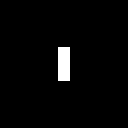

In [13]:
bliker = library.get_pattern('blinker')

game = Game(grid_size=(11,11))
game.load_pattern(bliker, (5,4))

game.run(200)

filename = 'out.gif'
game.export_gif(filename, size=(128,128), frametime=500)
display(IPyImage(filename))

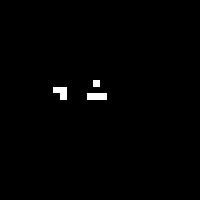

In [19]:
diehard = library.get_pattern('diehard')

game = Game(grid_size=(30,30))
game.load_pattern(diehard, (8,12))

game.run(100)

filename = 'out.gif'
game.export_gif(filename, size=(200,200), frametime=500)
display(IPyImage(filename))

break


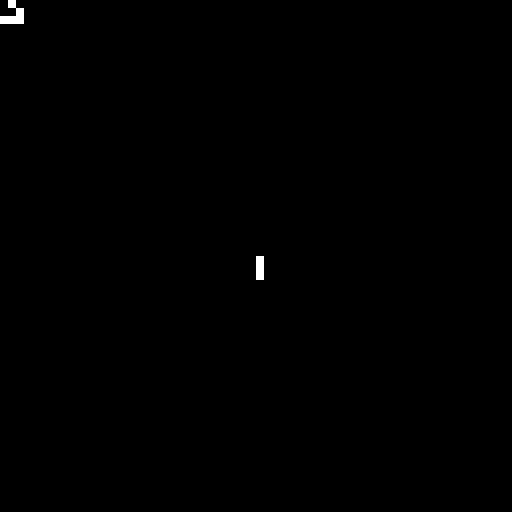

In [9]:
bliker = library.get_pattern('blinker')
glider = library.get_pattern('glider')

game = Game(grid_size=(64,64))
game.load_pattern(bliker, (32,32))
game.load_pattern(glider, (0,0))

game.run(500)

filename = 'out2.gif'
game.export_gif(filename, frametime=200)
IPyImage(filename)

In [17]:
def occupancy(pattern_name,iters):
    lib = PatternLibrary('patterns.csv')
    pattern = lib.get_pattern(pattern_name)
    
    #run the game to obtain the list with the number of active cells at each iteration
    g = Game(initial_state=None, grid_size=(64, 64))
    g.load_pattern(pattern, (0, 0))
    count=g.run(iters)
    print(count)
    
    iterations=[i for i in range(iters)]
    fig,ax = plt.subplots()
    plt.plot(iterations,count,linestyle="-",linewidth=1)
    plt.xlabel('Iterations')
    plt.ylabel('Occupancy')
    ax.set_xticks(iterations)
    plt.title(pattern_name+", occupancy per iteration")
    plt.savefig("occupancy.png")
    plt.show()
    
    return count

[8, 8, 11, 10, 10, 12, 12, 16, 16, 23, 18, 18, 22, 14, 12, 9, 4, 7, 6, 6, 8, 8, 12, 12, 19, 12, 13, 15, 11, 12, 12, 8, 14, 12, 12, 16, 16, 24, 24, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24, 28, 36, 24]


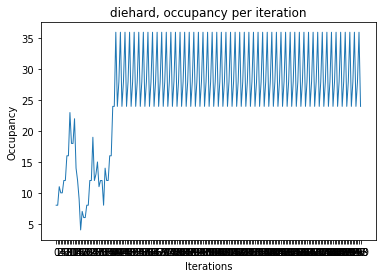

In [18]:
occ = occupancy('diehard',200)